# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** 
* Arild Madshaven
* Mathies Pollas Bjerg
* Theodor Tveit Husefest

**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [85]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

In [86]:
import skimage.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))

#### Visualization fns

In [87]:
def plotHist(im, dsc='', bins=256):
    'Plot image histogram'
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.hist(im.ravel(), bins=bins)
    ax.set_title(dsc)
    plt.show()

In [88]:
def plotImages(images, cmaps=None, dsc=None):
    'Visualize images side-by-side'
    
    n = len(images)
    if cmaps == None: cmaps = ['gray']*n
    if dsc == None: dsc = ['']*n
        
    fig, ax = plt.subplots(1, n, figsize=(6*n, 10))
    

    for i, im in enumerate(images):
        if n == 1:
            ax.imshow(im, cmap=cmaps[i], vmin=0, vmax=255)
            ax.set_title(dsc[i])
            ax.axis('off')
        else:
            ax[i].imshow(im, cmap=cmaps[i], vmin=0, vmax=255)
            ax[i].set_title(dsc[i])
            ax[i].axis('off')

    plt.show()

In [89]:
def plotImageAndHistogram(im, dsc='Image'):
    'Visualize image and its histogram side-by-side'
    
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].imshow(im, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(dsc)
    ax[1].hist(im.ravel(), 256)
    ax[1].set_title(dsc + ' histogram')
    plt.show()

## 1.2 Region growing

**First approach**: Try to detach brain tissue from skull by thresholding.

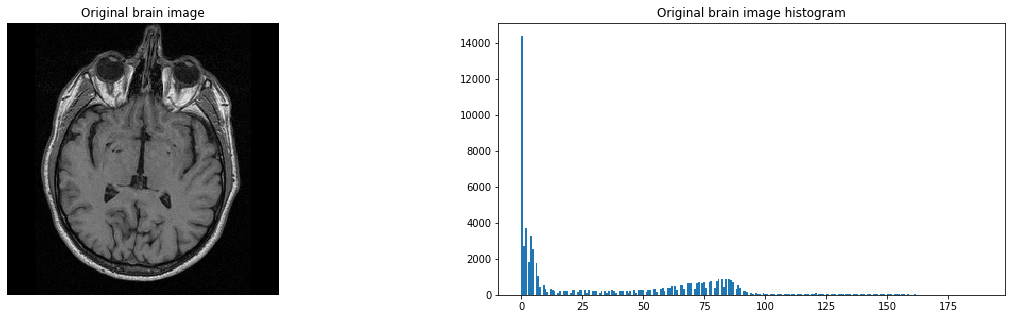

In [90]:
plotImageAndHistogram(brain_im, 'Original brain image')

**Thoughts**: 
   * The brain is light grey and partly surrounded by a dark ring. At the top it is connected to light matter. It should be possible to separate the brain from the surroundings by thresholding. This could make the region growing work easier. 
   * From the histogram we observe that most pixels are dark and few are bright, though there is a peak between 75 and 100. This is probably where the brightest area of the skull is. Our brain tissue is probably somewhere in between.
   * A lower threshold of 45 and upper threshold of 91 yielded a good result in our estimation. These boundaries were approached by extensive testing.

In [91]:
def thresholder(im, l_thr, u_thr, invert=False, three_shades=False):
    'Return image where pixel values outside threshold boundaries are maximized or minimized'
    
    trf = im.copy()
    
    lower_mask = trf < l_thr
    upper_mask = trf > u_thr
    mid_mask = ~(lower_mask|upper_mask)
    
    if not invert:
        trf[lower_mask] = 0
        trf[upper_mask] = 255
    else:
        trf[lower_mask] = 255
        trf[upper_mask] = 0     
    if three_shades: trf[mid_mask] = 122
    return trf

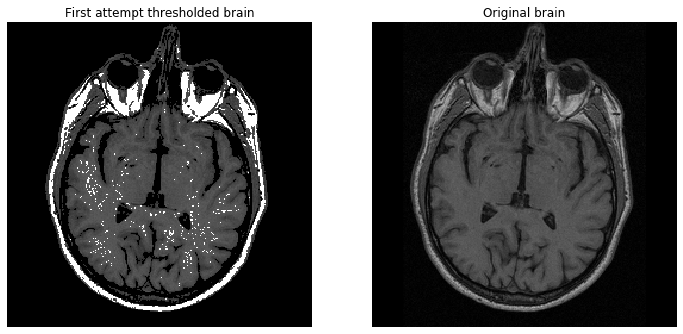

In [92]:
l_thr, u_thr = (45, 91)
t_brain = thresholder(brain_im, l_thr, u_thr)
plotImages([t_brain, brain_im], dsc=['First attempt thresholded brain', 'Original brain'])

**Thoughts**
* We initially set brighter areas to white and applied median filters to handle the 'salt' noise in the brain tissue.
* From here we would detect brain tissue as 'the large thing that is connex and neither white nor black'.
* *However* a more interesting result was achieved by setting bright pixels dark:

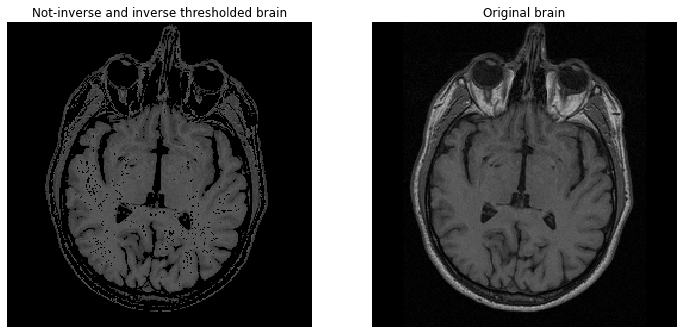

In [93]:
l_thr, u_thr = (45, 255)
t_brain = thresholder(brain_im, l_thr, u_thr)
l_thr, u_thr = (0, 91)
t_brain = thresholder(t_brain, l_thr, u_thr, invert=True)
plotImages([t_brain, brain_im], dsc=['Not-inverse and inverse thresholded brain', 'Original brain'])

**Thoughts**
* A trade-off has to be made between sparsity of connections between brain and skull, and loss of brain pixels.
* The lower the upper threshold, the more 'pepper' inside the brain, and the sparser the connections.
* We ended up implementing a gaussian filter at the start of the process to even out the brain tissue pixel values.

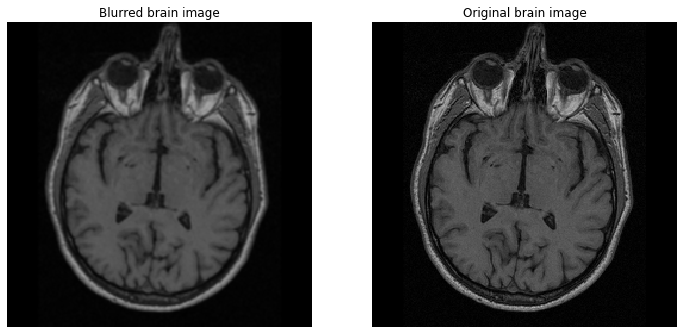

In [94]:
b_brain = cv2.GaussianBlur(brain_im, (3,3), 1)
plotImages([b_brain, brain_im], dsc=['Blurred brain image', 'Original brain image'])

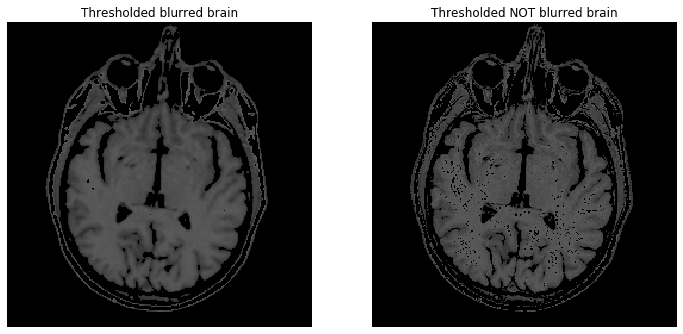

In [95]:
l_thr, u_thr = (45, 255)
tb_brain = thresholder(b_brain, l_thr, u_thr)
l_thr, u_thr = (0, 91)
tb_brain = thresholder(tb_brain, l_thr, u_thr, invert=True)
plotImages([tb_brain, t_brain], dsc=['Thresholded blurred brain', 'Thresholded NOT blurred brain'])

**Continuing to work on the blurred, thresholded image**

The weak connections can be broken by opening. Structuring element was chosen to minimize colatteral damage to the image. I.e. as small as possible.

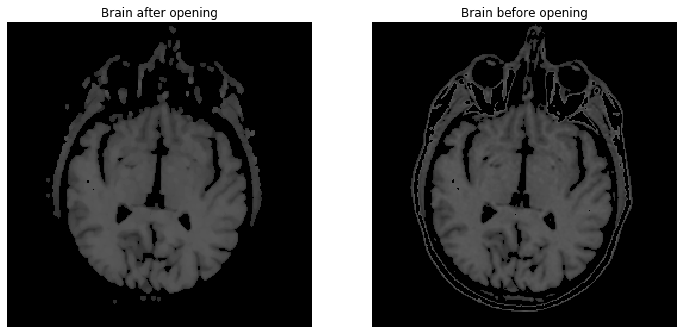

In [96]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,4))
o_brain = cv2.morphologyEx(tb_brain, cv2.MORPH_OPEN, kernel)
plotImages([o_brain, tb_brain], dsc=['Brain after opening', 'Brain before opening'])

**Thoughts**
* The brain is the largest 'not-black thing'.
* Initially we found the region by identifying *one* pixel coordinate that is part of the brain and use it as a single seed.
* We expanded on the algorithm to make a grid of seeds across the image.
* For the time being, it is sufficient that every seed identifies its neighbours which are *not black*.


In [97]:
def createIndexGrid(image_shape, distance):
    'Creates an evenly spaced grid of coordinates across an image'
    
    indices = []
    
    for xi in range(image_shape[0]):
        for yi in range(image_shape[1]):
            if (xi%distance, yi%distance)==(0,0): 
                indices.append((xi, yi))            
    return indices

In [98]:
def markIndices(im, indices, exaggerate=False):
    'Returns a copy of the image where indices are white'
    'Exaggerate to ease visualization'
    
    tp = im.copy()
    ind = np.array(indices)
    x, y = ind[:,0], ind[:,1]
    tp[x, y] = 255
    
    if exaggerate: 
        for i in range(-1,2):
            for j in range(-1,2):
                tp[x-i, y-j] = 255
    return tp

**Ensure** at least one seed is within brain tissue.

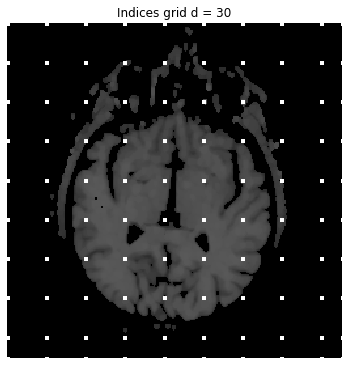

In [99]:
seed_d = 30

seeds = createIndexGrid(o_brain.shape, seed_d)
ind_im = markIndices(o_brain, seeds, exaggerate=True)
plotImages([ind_im], dsc=[f'Indices grid d = {seed_d}'])

In [100]:
def neighbourInRange(lower, upper, neighbour, _):
    'Helper fn for region growing'
    
    return lower < neighbour < upper

In [101]:
def collectRegion(seed, visited, im, lower_threshold, upper_threshold, fn=neighbourInRange, HIGHEST_PIX_VALUE=255):
    'Returns a region of pixel coordinate neighbours which satisfy the region criterion set by _fn_'

    detected = set([seed])
    region = set()

    x_min = y_min = 0
    x_max, y_max = im.shape
    
    while len(detected):
        
        pix = detected.pop()
        
        if pix in visited: continue
                
        pix_val = im[pix]
        
        x, y = pix
    
        for xi in range(max(x-1, x_min), min(x+2, x_max), 2):
            if ((xi, y)) in visited: continue
            if fn(lower_threshold, upper_threshold, im[xi, y], pix_val): detected.add((xi, y))
        for yi in range(max(y-1, y_min), min(y+2, y_max), 2):
            if ((x, yi)) in visited: continue
            if fn(lower_threshold, upper_threshold, im[x, yi], pix_val): detected.add((x, yi))
                
        region.add(pix)
        visited.add(pix)
        
    return list(region)

In [102]:
def collectAllRegions(seeds, im, min_region_size, max_region_size, l_thr, u_thr, fn=neighbourInRange):
    'Runs collectRegion for every seed and returns a list of all connex regions in the image'
    
    regions = []
    visited = set()

    for seed in seeds:
        
        if seed in visited: continue
            
        region = collectRegion(seed, visited, im, l_thr, u_thr, fn=fn)
        
        if min_region_size <= len(region) <= max_region_size: regions.append(region)
        
        
    return regions, visited

In [103]:
l_thr, u_thr = (1, 255)
min_region_size = 1000
max_region_size = float('inf')

'For the time being - we are looking for pixels that are NOT all black, and an area of - say - at least 1000 connex pixels'

regions, visited_pixels = collectAllRegions(seeds, o_brain, min_region_size, max_region_size, l_thr, u_thr)

In [104]:
len(regions)

3

So **three** regions satisfy these criterions. Let's try to visualize them on the original brain:

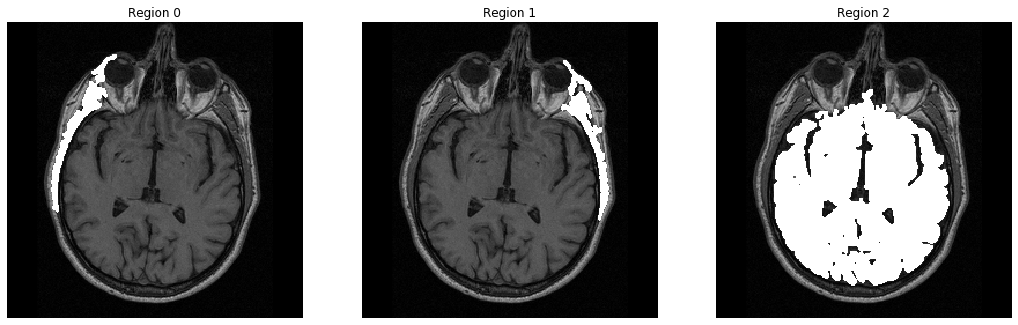

In [105]:
ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

**Clearly** we're looking for region 2. The size of which is the measured size of the brain.

In [106]:
result_threshold_opening = ind_brains[2]
size_threshold_opening = len(regions[2])
print(f'Estimated brain size: {size_threshold_opening}')

Estimated brain size: 17502


**Thoughts**
* The measurement is crude, probably due to sub-optimal thresholding, blurring and opening.
* What if we used a *relative* criterion instead of an absolute threshold? That is - neighbours that *look* alike are part of the same region.

In [107]:
def neighbourInRelativeRange(lower, upper, neighbour, current):
    'Helper fn for region growing'
    
    return current-lower < neighbour < current+upper

Trying first to grow regions based on the original image and the seed grid from before:

In [108]:
l_thr, u_thr = (8, 8)
min_region_size = 1000
max_region_size = float('inf')

regions, visited_pixels = collectAllRegions(seeds, brain_im, min_region_size, max_region_size, l_thr, u_thr, fn=neighbourInRelativeRange)

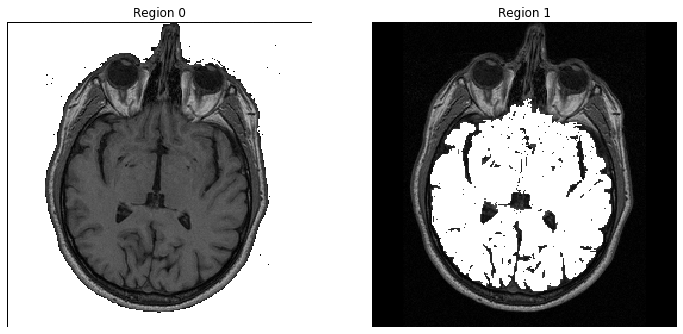

In [109]:
ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

Still yields some noise and boundary issues, so we'll apply gaussian filter and thresholding like before the previous opening  

In [110]:
l_thr, u_thr = (5, 5)
min_region_size = 1000
max_region_size = float('inf')

'tb_brain is the thresholded and blurred brain from before opening'

regions, visited_pixels = collectAllRegions(seeds, tb_brain, min_region_size, max_region_size, l_thr, u_thr, fn=neighbourInRelativeRange)

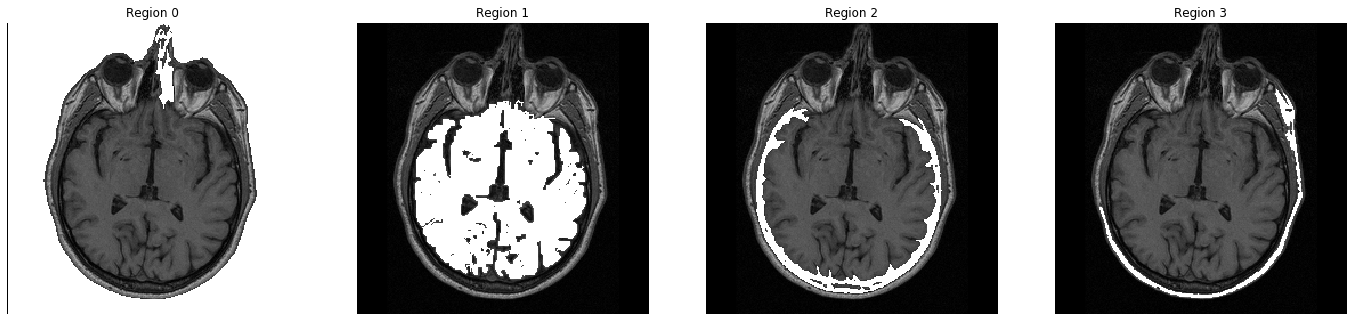

In [111]:
ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

**Region 1** is our brain. We'll see how it looks compared to our old best result:

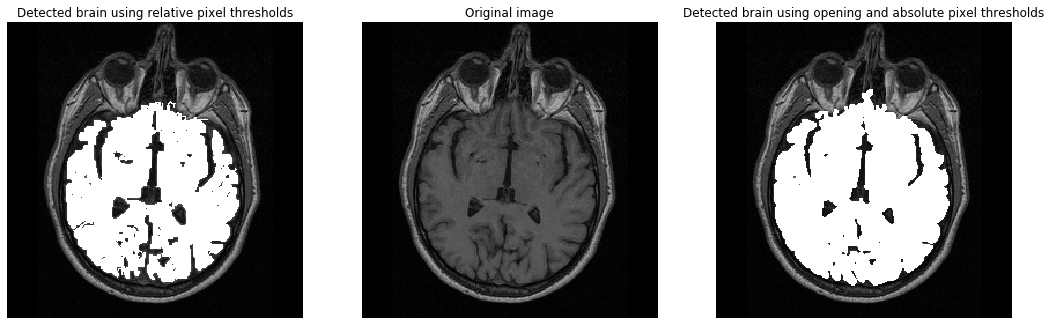

In [112]:
result_relative_neighbours = ind_brains[1]
size_relative_neighbours = len(regions[1])
plotImages([result_relative_neighbours, brain_im, result_threshold_opening], 
           dsc=['Detected brain using relative pixel thresholds', 'Original image', 'Detected brain using opening and absolute pixel thresholds'])

In [113]:
print(f"Estimated size of brain: {size_relative_neighbours}")

Estimated size of brain: 15344


### 1.2.1 Discussion

"Brain using opening and absolute pixel thresholds" (Image 1) gave a 2158 larger brain size compared to "using relative pixel thresholds"(Image 2). Comparing the marked areas of brain image 1 and 2 to the original image, more contours and smaller black areas are more present at image 2. Image 2 looks to have the most valid representation of the brain. The loss of the smaller black areas of image 1 could be due to, overapplying opening and thereby closing the black sections.

## 1.3 Contour detection

**First approach:** Constructing a Marr-Hildreth kernel

In [114]:
def LoG(sigma, x, y):
    'Laplacian of Gaussian equation'
    return -1/(np.pi * sigma**4)*np.exp(-(x**2+y**2)/(2*sigma**2))*(1 - (x**2+y**2)/(2*sigma**2))

In [115]:
from sklearn.preprocessing import normalize

def constructLoGKernel(sigma, size=7):
    'Returns kernel approximation of the LoG equation'
    'Larger simga implies more noise reduction'
    'Larger size implies better filter approximation'
    
    assert size%2, 'Kernel must be odd'
    
    kernel = np.zeros((size,size))
    mid = size//2
    
    for y in range(-mid, mid+1):
        for x in range(-mid, mid+1):
            kernel[x+mid, y+mid] = LoG(sigma,x,y)
            
    kernel = normalize(kernel, axis=1, norm='l1')
    return kernel

In [116]:
def printKernel(k, dsc='',round_val=2):
    
    print(dsc)
    for row in k:
        for e in row: print(round(e, 2), end='\t')
        print()

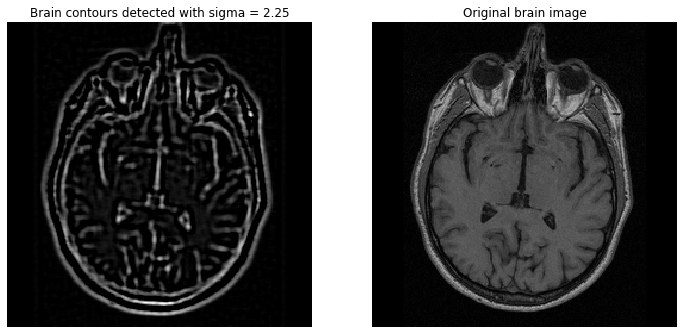

Marr-Hildreth kernel
0.09	0.12	0.13	0.12	0.11	0.12	0.13	0.12	0.09	
0.17	0.18	0.11	-0.01	-0.06	-0.01	0.11	0.18	0.17	
0.08	0.05	-0.06	-0.19	-0.25	-0.19	-0.06	0.05	0.08	
0.04	-0.0	-0.1	-0.22	-0.27	-0.22	-0.1	-0.0	0.04	
0.03	-0.01	-0.11	-0.22	-0.26	-0.22	-0.11	-0.01	0.03	
0.04	-0.0	-0.1	-0.22	-0.27	-0.22	-0.1	-0.0	0.04	
0.08	0.05	-0.06	-0.19	-0.25	-0.19	-0.06	0.05	0.08	
0.17	0.18	0.11	-0.01	-0.06	-0.01	0.11	0.18	0.17	
0.09	0.12	0.13	0.12	0.11	0.12	0.13	0.12	0.09	


In [117]:
sigma = 2.25 
kernel_size = 9
LoG_kernel = constructLoGKernel(sigma, kernel_size)

brain_LoG = cv2.filter2D(brain_im, -1, LoG_kernel) 
plotImages([brain_LoG, brain_im], dsc=[f'Brain contours detected with sigma = {sigma}', 'Original brain image'])
printKernel(LoG_kernel, 'Marr-Hildreth kernel')

**Thoughts**
* We settled for a kernel size of 9. Different sizes were tried, but 9 seemed to be more than sufficient to approximate the filter.
* The ideal value range for sigma is very narrow. We tried to select sigma s.t. a more or less connext brain region could be achieved.
* Would results be better if we could stretch the histogram a bit?

In [118]:
def normalizeHist(im, new_max):
    'Return image where pixel values are stretched from 0 to new_max'
    
    c = im.copy().astype('float64')
    min_val = c.min()
    max_val = c.max()
        
    c -= min_val
    c /= (max_val - min_val)
    
    return (c * new_max).astype('uint8')

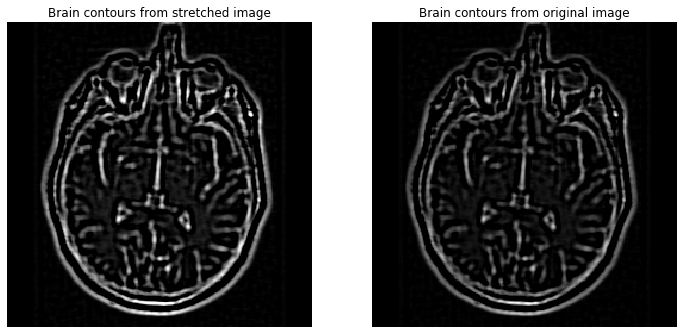

In [119]:
n_brain = normalizeHist(brain_im, 255)
n_brain_LoG = cv2.filter2D(n_brain, -1, LoG_kernel) 
plotImages([n_brain_LoG, brain_LoG], dsc=[f'Brain contours from stretched image', 'Brain contours from original image'])

Edges are definitely stronger after image is stretched. This might give us room to increase sigma a bit.

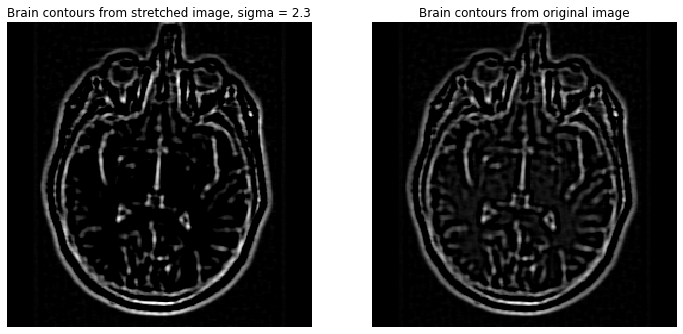

In [120]:
sigma = 2.3 
LoG_kernel = constructLoGKernel(sigma, kernel_size)
n_brain_LoG = cv2.filter2D(n_brain, -1, LoG_kernel) 
plotImages([n_brain_LoG, brain_LoG], dsc=[f'Brain contours from stretched image, sigma = {sigma}',
                                          'Brain contours from original image'])

**Applying closing** to achieve enclosed brain region

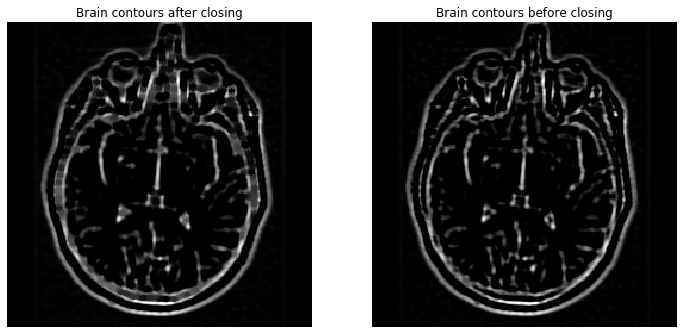

In [121]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
c_brain_LoG = cv2.morphologyEx(n_brain_LoG, cv2.MORPH_CLOSE, kernel)
plotImages([c_brain_LoG, n_brain_LoG], dsc=['Brain contours after closing', 'Brain contours before closing'])

**Again**, applying seeds. Now looking for larger black regions.

In [122]:
seed_d = 40
seeds = createIndexGrid(c_brain_LoG.shape, seed_d)

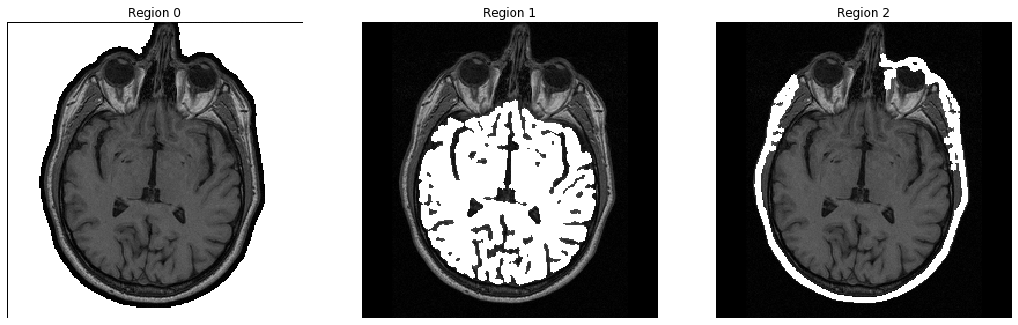

In [123]:
l_thr, u_thr = (-1, 20)
min_region_size = 1000
max_region_size = float('inf')

regions, visited_pixels = collectAllRegions(seeds, c_brain_LoG, min_region_size, max_region_size, l_thr, u_thr)

ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

Region 1 looks quite good. Fetching our newest brain size estimate:

In [124]:
result_LoG = ind_brains[1]
size_LoG = len(regions[1])
print(f'Size of brain: {size_LoG}')

Size of brain: 15444


## 1.3 Additional method(s)

### Canny edge detection

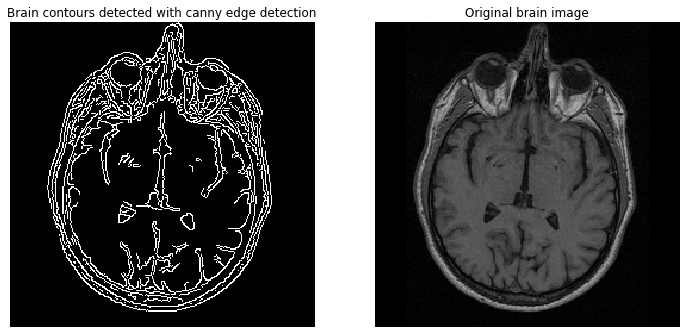

In [125]:
'Set upper threshold to be three times lower threshold and fine-tune lower threshold'

l_thr = 70
u_thr = 3*l_thr
canny_brain = (cv2.Canny(brain_im, l_thr, u_thr))
plotImages([canny_brain, brain_im], dsc=['Brain contours detected with canny edge detection', 'Original brain image'])

**Applying** fine-grained closing to ensure enclosed brain

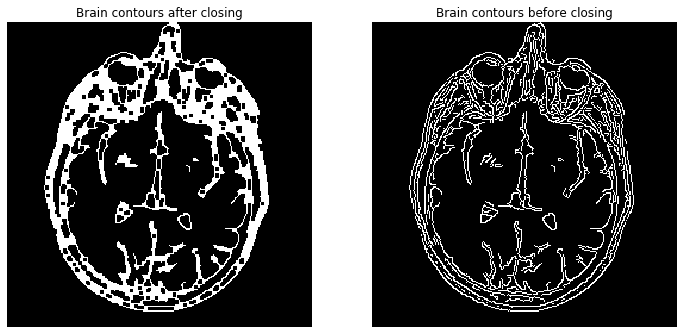

In [126]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
ccanny_brain = cv2.morphologyEx(canny_brain, cv2.MORPH_CLOSE, kernel)
plotImages([ccanny_brain, canny_brain], dsc=['Brain contours after closing', 'Brain contours before closing'])

In [127]:
seed_d = 40
seeds = createIndexGrid(ccanny_brain.shape, seed_d)

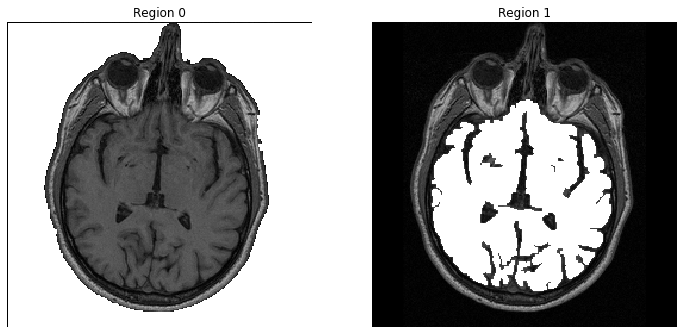

In [128]:
l_thr, u_thr = (-1, 20)
min_region_size = 1000
max_region_size = float('inf')

regions, visited_pixels = collectAllRegions(seeds, ccanny_brain, min_region_size, max_region_size, l_thr, u_thr)

ind_brains = [markIndices(brain_im, r) for r in regions]
plotImages(ind_brains, dsc=[f'Region {i}' for i in range(len(regions))])

In [129]:
result_canny = ind_brains[1]
size_canny = len(regions[1])
print(f'Estimated brain size: {size_canny}')

Estimated brain size: 15536


### Discussion

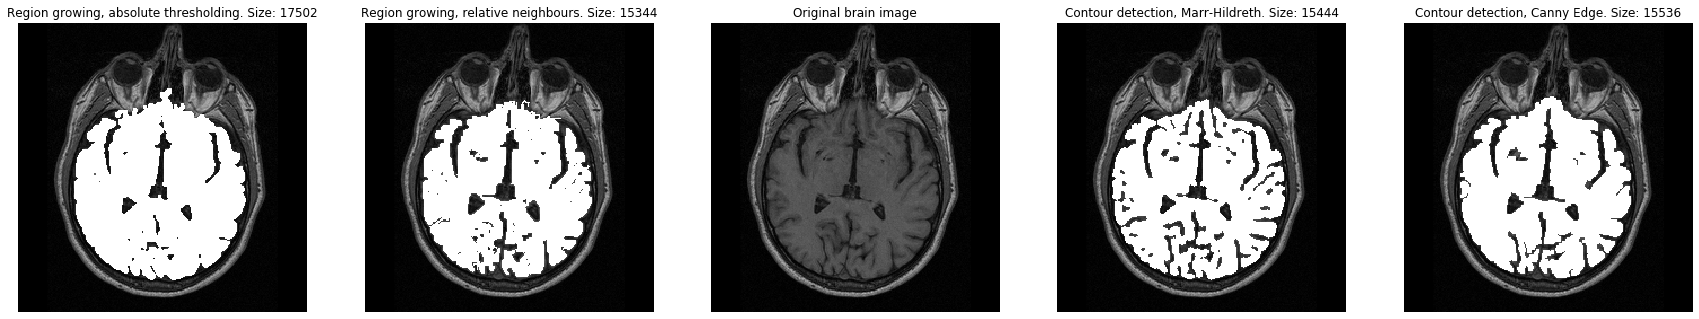

In [130]:
plotImages([result_threshold_opening, result_relative_neighbours, brain_im, result_LoG, result_canny],
          dsc=[f'Region growing, absolute thresholding. Size: {size_threshold_opening}',
               f'Region growing, relative neighbours. Size: {size_relative_neighbours}',
               'Original brain image',
               f'Contour detection, Marr-Hildreth. Size: {size_LoG}',
               f'Contour detection, Canny Edge. Size: {size_canny}'])

**Thoughts:**
* Three images are in the same brain size range: 15344 - 15536. 
* The first image is notable bigger in size, as previous mentioned this is most likely due to the loss of small contours cause by to much opening / preprocessing.
* The Marr-Hildreth method worked well, after some image restoration. The success of this method is probably due to the simple nature of the picture, which results in a small noise contribution. Although [wikipedia](https://en.wikipedia.org/wiki/Marr%E2%80%93Hildreth_algorithm) claims the Marr-Hildreth "today [is] mainly of historical interest" it turned out to yield a nice result on this task.

* Furthermore, it should be noted that a successful brain size estimation was obtained using region growing and region growing on contour detection.

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [131]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
NUM_IMAGES = images.shape[0]
NUM_COLORS = images.shape[-1]
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


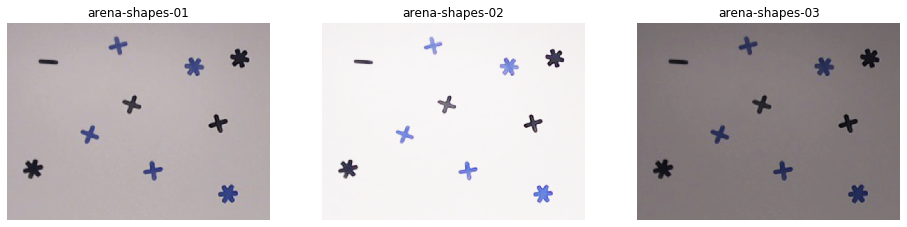

In [132]:
# Plot images
def plot_imgs(images, cmap = None, im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']):
    fig, axes = plt.subplots(1, NUM_IMAGES, figsize=(16, 16))
    for ax, im, nm in zip(axes.ravel(), images, im_names):
        ax.imshow(im, cmap = cmap)
        ax.axis('off')
        ax.set_title(nm)
    plt.show()

plot_imgs(images)

### Preprocessing

In this section we wish to preprocess the images such that it is possible to segment the colors regardless of image intensity. Following techniques are applied:  

- RBG to Greyscale
- Normalizing
- Standardizing
- Intensity rescaling


#### RGB to Greyscale

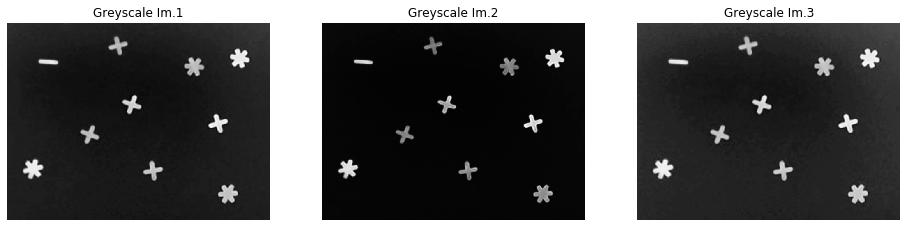

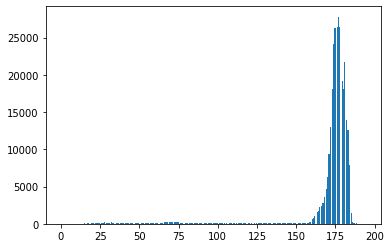

In [133]:
from skimage.color import rgb2grey
greys = [(rgb2grey(images[i])*255).astype(int) for i in range(NUM_IMAGES)]

plot_imgs(greys, cmap = 'Greys', im_names = ['Greyscale Im.1', 'Greyscale Im.2', 'Greyscale Im.3'])

plt.hist(greys[0].ravel(), bins = 256)
plt.show()


**Thoughts:**

Working with greyscale is in many ways easier than RGB. However, this cannot be used here as we can see in the histogram above.  
We only get one peak, which makes it very hard to distingush the different colors.

#### Normalizing images

Mean pixel value before: 174.48659288194443
Mean pixel value after: 216.29489691840277

Mean pixel value before: 241.1303949652778
Mean pixel value after: 244.39402886284722

Mean pixel value before: 118.77575629340278
Mean pixel value after: 202.63930989583332



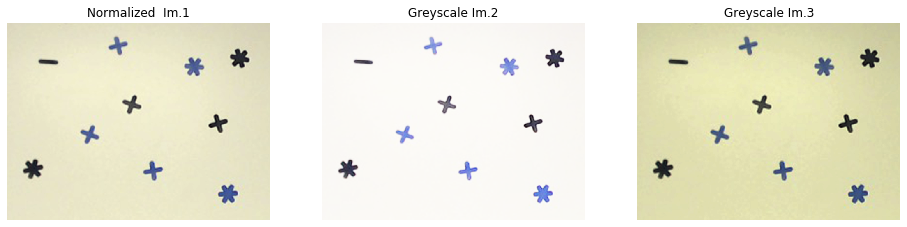

In [134]:
def normalize_img(img):
    print('Mean pixel value before:', np.mean(img) )
    img_min = img.min(axis = (0, 1))
    img_max = img.max(axis = (0, 1))
    norm_img = (((img - img_min)/(img_max-img_min))*255).astype(int)
    print('Mean pixel value after:', np.mean(norm_img))
    print()
    return norm_img
    
    
norm_imgs = [normalize_img(images[i]) for i in range(NUM_IMAGES)]
plot_imgs(norm_imgs,  im_names = ['Normalized  Im.1', 'Greyscale Im.2', 'Greyscale Im.3'])

**Thoughts:**

Normalizing is done by taking advantage of the whole spectrum of 0-255 values, in each channel (RGB). As seen in the above pictures the result does not differ much from the original image. This technique is therefore disgarded.

#### Standardizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


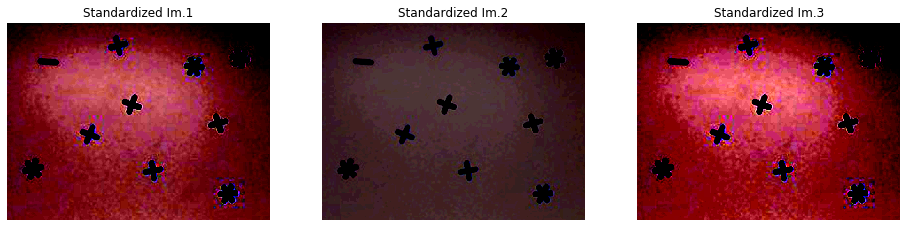

In [135]:
# Standardizing removes to much color information

def standardize_img(img):
    
    img_mean = img.mean()
    img_std = img.std()
    std_img = ((img-img_mean)/img_std)

    return std_img

std_imgs = [standardize_img(images[i]) for i in range(NUM_IMAGES)]
plot_imgs(std_imgs, im_names = ['Standardized Im.1', 'Standardized Im.2', 'Standardized Im.3'])


**Thoughts:**

Standardizing produces zero-mean and standard deviation of 1. Although the images are not as bad as in the images above (which clips all negative values), this method resulted in too much loss of color information. Therefore this technique is disregarded.

#### Rescale Intensity

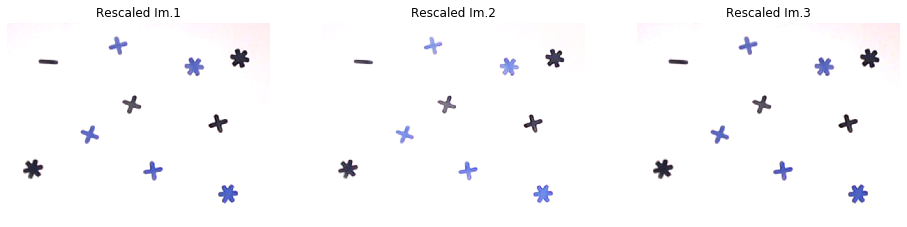

In [138]:
from skimage.exposure import rescale_intensity


def equalize_intensity(img):
    """
    """
    p2, p98 = np.percentile(img, (0, 10))
    return rescale_intensity(img, in_range=(p2,p98))


eq_imgs = [equalize_intensity(images[i]) for i in range(NUM_IMAGES)]

plot_imgs(eq_imgs, im_names = ['Rescaled Im.1', 'Rescaled Im.2', 'Rescaled Im.3'])

**Thoughts:**

As seen in the above pictures, Rescale Intensity produces by far the best result. The method uses the darker (lower) values of the image, while setting all grey parts to white. 

### 2.2 Number of shapes of each color
Add your implementation and discussion

Histogram of equalized image nr. 1


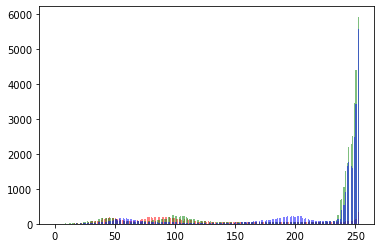

Histogram of equalized image nr. 2


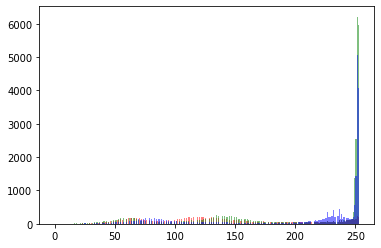

Histogram of equalized image nr. 3


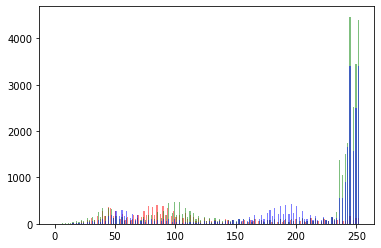

In [137]:
def remove_white(img, ch):
    '''
    Help function so that histogram is not dominated by white pixels
    '''
    img_ch = img[:,:, ch].ravel()
    return img_ch[img_ch != 255]
    
def plot_rgb_hist(img):
    ''' 
    Plots histogram of each channel/color on top of eachother.
    '''
    plt.hist(remove_white(img, 0), bins = 255, color = 'red', alpha = 0.5)
    plt.hist(remove_white(img, 1), bins = 255, color = 'green', alpha = 0.5)
    plt.hist(remove_white(img, 2), bins = 255, color = 'blue', alpha = 0.5)
    
    plt.show()

for i in range(3):
    print('Histogram of equalized image nr.', i + 1)
    plot_rgb_hist(eq_imgs[i])
    
plt.show()

**Thoughts:**

The images shows distinctive peaks of different gaussian distributions, which should be able to provide us with threshold values. Furthermore, the peak at 250 corresponds to the many white pixel observations.

## Segmentation
In this section we wish to do thresholding and labeling of the regions

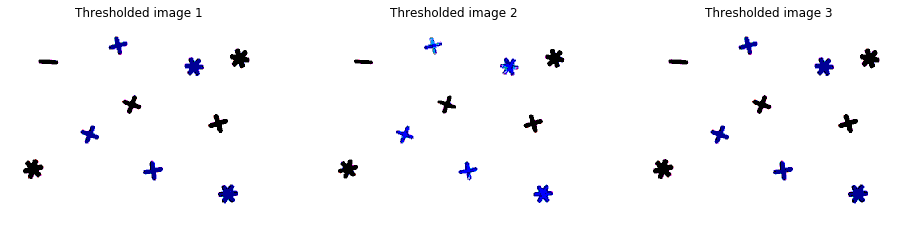

In [63]:
def thresholding(img):
    '''
    Has a lower and upper threshold which is used to segment the two colors
    Values have been found from looking at histogram.
    '''
    lt = 160

    ut = 230
    
    thres_img = img.copy()
    
    thres_img[thres_img < lt] = 0
    thres_img[(thres_img >= lt) & (thres_img < ut) ] = 150
    thres_img[thres_img >= ut] = 255
    
    return thres_img
    

imgs_thres = [thresholding(eq_imgs[i]) for i in range(NUM_IMAGES)]
plot_imgs(imgs_thres, im_names = ['Thresholded image 1', 'Thresholded image 2', 'Thresholded image 3'])

### Region Growing

In [139]:
def is_white(pixel):
    '''
    Check if all RBG values are white
    '''
    return  np.all(np.isin(pixel, 255))

def collect_region(start, im_arr):
    '''
    Moves out from start and ads pixel to region if it is not white.
    Is running as long as there are are connected non-white pixels.
    '''

    detected = set([start])
    visited = set()

    x_min = y_min = 0
    x_max, y_max = im_arr.shape[0:2]
    
    while len(detected):
        
        pix = detected.pop()
        if pix in visited: continue

        x, y = pix
        for xi in range(max(x-2, x_min), min(x+2, x_max), 1):
            if not is_white(im_arr[xi, y]): detected.add((xi, y))
        for yi in range(max(y-2, y_min), min(y+2, y_max), 1):
             if not is_white(im_arr[x, yi]): detected.add((x, yi))
        
        visited.add(pix)  
    
    return visited


In [140]:
import time
def region_growing(img):
    
    '''
    Goes through all pixels and adds region.
    Has a minimum region-size in case of left out pixels.
    
    '''
    
    min_region_size = 50
    regions = []
    visited_pixels = set()
    
    tic = time.time()
    count = 0
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            
            if is_white(img[row, col]) or (row, col) in visited_pixels: continue
            count -=- 1
            region = collect_region((row, col), img)
            
            if len(region) > min_region_size: regions.append(region)
            visited_pixels |= region
            
    toc = time.time()

    print('Found {} regions in {} seconds.'.format(len(regions), np.around(toc-tic)))
    return regions


Executing function: median



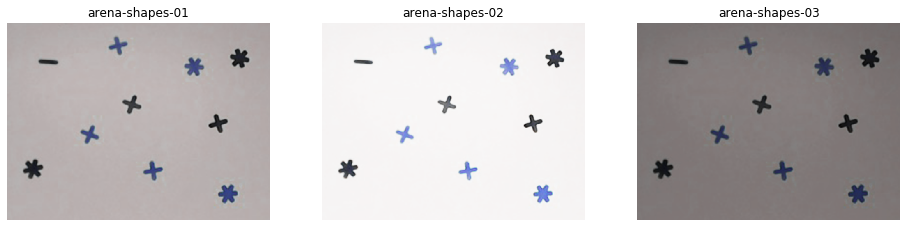

Executing function: equalize_intensity



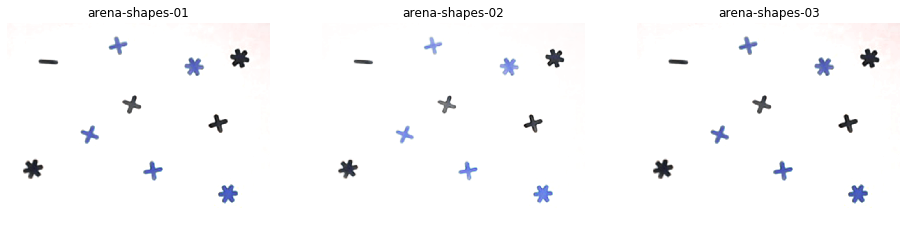

Executing function: thresholding



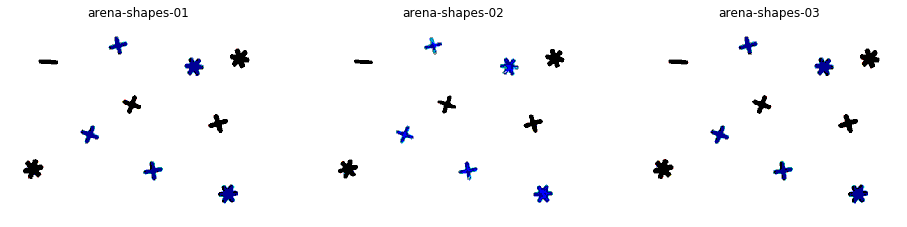

Executing function: region_growing

Found 10 regions in 5.0 seconds.
Found 10 regions in 5.0 seconds.
Found 10 regions in 5.0 seconds.


In [141]:
from skimage.filters import median

def pipeline(imgs, functions, visual=False):
    '''
    Help function to easily test different combinations of functions.
    
    '''
    for f in functions:
        print('Executing function: {}\n'.format(f.__name__))
        imgs = [f(imgs[i]) for i in range(NUM_IMAGES)]
        if visual and f.__name__ != 'region_growing':
            try:
                plot_imgs(imgs)
            except: 
                pass
        
    return imgs

imgs_regions = pipeline(images, [median, equalize_intensity, thresholding, region_growing], visual=True)

**Thoughts:**

10 Regions found in all three images, which is the expected amount.

### Label Regions

In [167]:
def calculate_regions_mean(img, regions):
    '''
    Returns the mean of each region in one image.
    
    '''
    np_regions = []
    for region in regions:
        np_region = []
        for x, y in region:
            np_region.append(img[x, y])
        np_regions.append(np.asarray(np_region).mean())
    
    return np.asarray(np_regions)
            

def label_regions(means):
    '''
    Return array with color of each region.
    '''
    threshold = means.mean() # Calculate average value of means
    labels = []
    for region, mean in enumerate(means):
        if mean >= threshold:
            labels.append('blue')
        else: 
            labels.append('black')
    
    return np.asarray(labels)
    
    
regions_means = [calculate_regions_mean(imgs_thres[i], imgs_regions[i]) for i in range(NUM_IMAGES)]
labels = [label_regions(regions_means[i]) for i in range(NUM_IMAGES)]


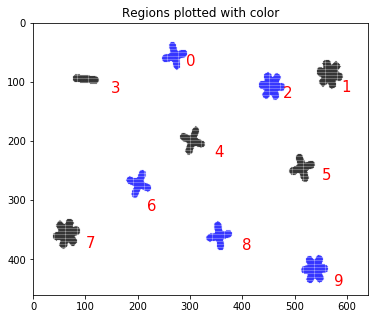

In [68]:
def plot_regions(regions, labels):
    '''
    Used to plot the regions to check results.
    
    '''
    f = plt.figure(figsize = (6,5))
    for nr, region in enumerate(regions):
        for x, y in region:
            plt.scatter(y, x, s = 0.01, color = labels[nr] )

        plt.text(y + 25, x + 25, nr, fontsize = 15, color = 'red')
    
    x_min, x_max, y_min, y_max = 0, 640, 0, 460
    plt.axis([x_min, x_max, y_max, y_min]) # Revert y_axis

    plt.title('Regions plotted with color')
    plt.show()
        
plot_regions(imgs_regions[0], labels)

### Results

In [169]:
true_labels = np.asarray(['blue', 'black', 'blue', 'black', 'black', 'black', 'blue',
       'black', 'blue', 'blue'])
print('Accuracy of segmentation: {}%'.format(np.mean(labels[0] == true_labels)*100))
colors, count = np.unique(labels[0], return_counts = True) 
for i in range(len(colors)):
    print('Found {} objects in the color {}'.format(count[i], colors[i]))

Accuracy of segmentation: 100.0%
Found 5 objects in the color black
Found 5 objects in the color blue


### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [173]:
def calculate_color_area(img_regions, labels):
    '''
    Calculates the area of each region based on found regions and labelling.
    
    '''
    area_blue = 0
    area_black = 0
    for i, region in enumerate(img_regions):
        if labels[i] == 'blue':
            area_blue += len(region)
        else:
            area_black += len(region)
            
    return area_blue, area_black
    
    
for i in range(NUM_IMAGES):    
    
    print('Image {}'.format(i))
    area_blue, area_black = calculate_color_area(imgs_regions[i], labels[i])
    print('Number of blue pixels: {}. Number of black pixels: {}.\n'.format(area_blue, area_black))

Image 0
Number of blue pixels: 6037. Number of black pixels: 5836.

Image 1
Number of blue pixels: 5352. Number of black pixels: 5224.

Image 2
Number of blue pixels: 6143. Number of black pixels: 5931.



**Thoughts:**

As we can see from the calculations we have a little more blue pixels than black.  
Altough there are some differences between the images, we can say that this solution regarding intenensity worked decently in this problem. By only focusing on the lower/darker values in the images we were able to segment out the different colors, but this will take some tuning if the same method is used on other images.  
Anther method that problably could work quite well on these images are active contours with level set method, but was not implemented in this task.

---

### Part 2 - Take 2

This second approach does not consider explicit intensity normalization per se. Initially we tried to separate the background from the foreground by using the 'neighbours are relatively alike' approach.

After identifying the background, it's trivial to identify what's *not* background.

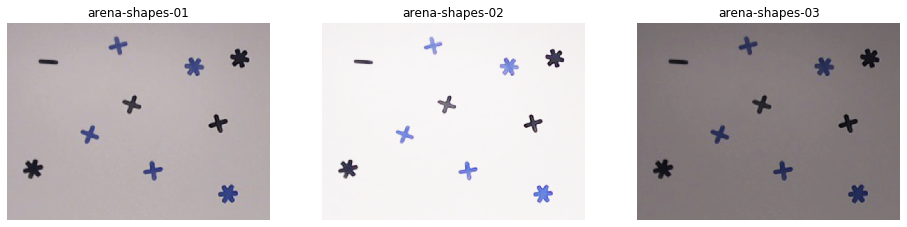

In [144]:
plot_imgs(images)

**Each pixel** holds three values, for Red, Green and Blue, respectively.

Extracting the different pixel value, thus creating gray-scale pictures based on the three base colors.

In [145]:
im_reds = [np.array([[p[0] for p in r] for r in im]) for im in images]
im_greens = [np.array([[p[1] for p in r] for r in im]) for im in images]
im_blues = [np.array([[p[2] for p in r] for r in im]) for im in images]

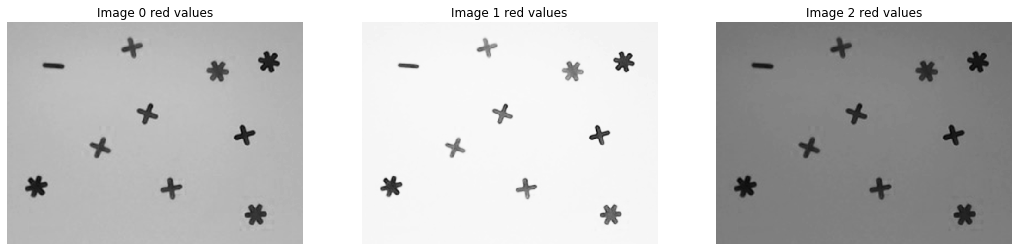

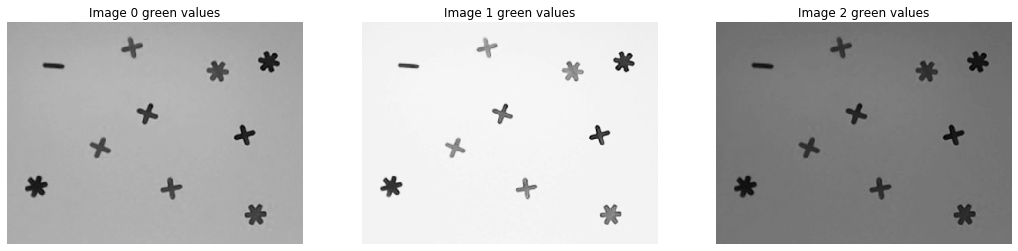

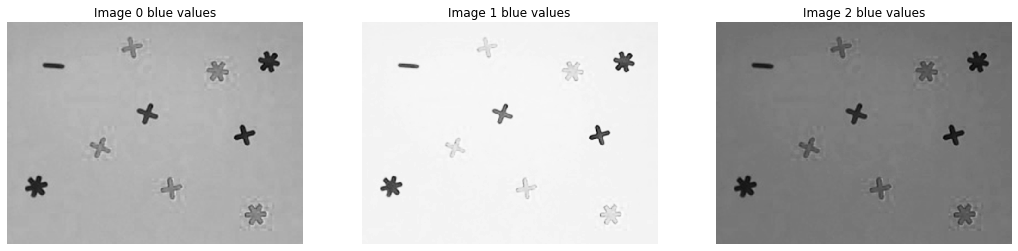

In [146]:
plotImages(im_reds, dsc=[f'Image {i} red values' for i in range(len(im_reds))])
plotImages(im_greens, dsc=[f'Image {i} green values' for i in range(len(im_greens))])
plotImages(im_blues, dsc=[f'Image {i} blue values' for i in range(len(im_blues))])

**Thoughts**
* The blue values are the ones we should probably work on.
* This makes sense, since the figures are either blue or black.

**Identify background** as a large area that consists of relatively similar neighbours

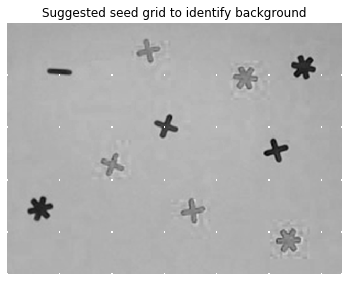

In [147]:
seed_d = 100

seeds = createIndexGrid(im_blues[0].shape, seed_d)
ind = markIndices(im_blues[0], seeds, exaggerate=True)
plotImages([ind], dsc=['Suggested seed grid to identify background'])

In [148]:
min_region_size = 5000
max_region_size = float('inf')

l_thr = 3
u_thr = 3

bgs = []

for im in im_blues:   
    regions, _ = collectAllRegions(seeds, im, min_region_size, max_region_size, l_thr, u_thr, fn=neighbourInRelativeRange)
    bgs.append(regions[0])

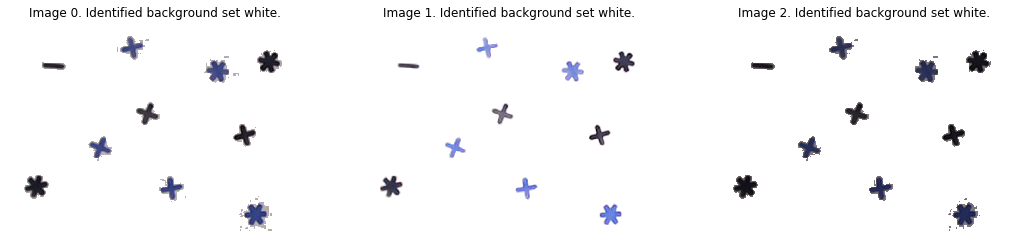

In [149]:
inds = [markIndices(im, r) for im, r in zip(images, bgs)]
plotImages(inds, dsc=[f'Image {i}. Identified background set white.' for i in range(len(inds))])

This wasn't all too good. Works well on the middle picture, but does not handle noise too well.

Attempts were made to remove this noise using bilateral, gaussian and median filters.

A more successful approach was to focus on identifying the explicit mean value of the background, and the other colors, and to threshold the image based on those values.

**Identify the three largest peaks in the histogram**, belonging hopefully to the three dominant colors.

In [150]:
from scipy.signal import find_peaks

N_PEAKS = 3
color_peaks = []

for im in im_blues:
    
    hist, bins = np.histogram(im.ravel(), bins=256)
    peaks = find_peaks(hist, distance=20) # Index of all peaks in histogram which satisfy distance criterion.

    peak_heights = hist[peaks[0]]
    n_peak_heights = np.sort(peak_heights)[-N_PEAKS:][::-1] # Get the explicit heights of the three most dominant peaks.
    n_peak_values = [bins[np.where(hist==h)][0] for h in n_peak_heights] # And locate which pixel values the peaks belong to.
    color_peaks.append(np.sort(n_peak_values))

In [151]:
color_peaks

[array([ 39.375, 133.875, 175.875]),
 array([ 78.07421875, 220.38671875, 243.1171875 ]),
 array([ 24.328125 ,  86.5      , 117.5859375])]

* **In image 0** the three most dominant colors have their peak at pixel value 39, 133 and 175
* **In image 1** the three most dominant colors have their peak at pixel value 78, 220 and 243
* **In image 2** the three most dominant colors have their peak at pixel value 24, 86 and 117

In [152]:
thresholded_ims = []

for i, im in enumerate(im_blues):
    peaks = color_peaks[i]
    l_thr = (peaks[0] + peaks[1]) / 2
    u_thr = (peaks[1] + peaks[2]) / 2
    thresholded_ims.append(thresholder(im, l_thr, u_thr, three_shades=True))

**Note**: We did not fit a gaussian curve to the histogram, but settled for thresholds between the peaks.

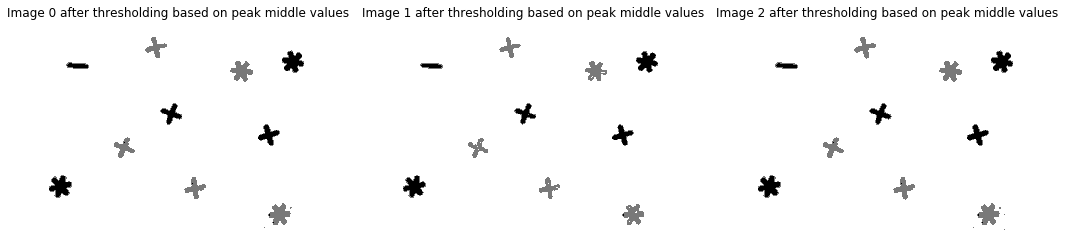

In [153]:
plotImages(thresholded_ims, dsc=[f'Image {i} after thresholding based on peak middle values' for i in range(len(thresholded_ims))])

Quite nice. Proceeding by:
* Looking for small regions that are not white.

In [154]:
seed_d = 2
seeds = createIndexGrid(im_blues[0].shape, seed_d)

min_region_size = 250
max_region_size = 5000

l_thr = -1
u_thr = 250

all_regions = []

for im in thresholded_ims:   
    regions, _ = collectAllRegions(seeds, im, min_region_size, max_region_size, l_thr, u_thr)
    all_regions.append(regions)

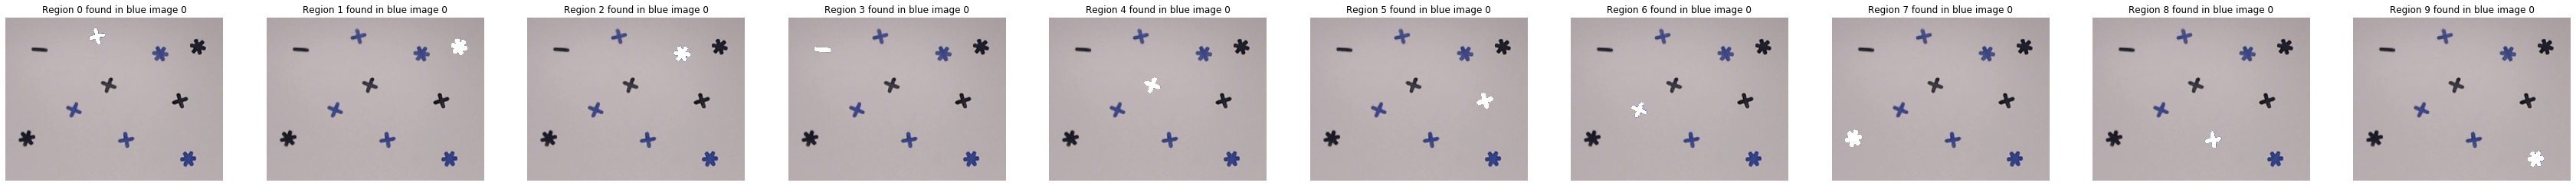

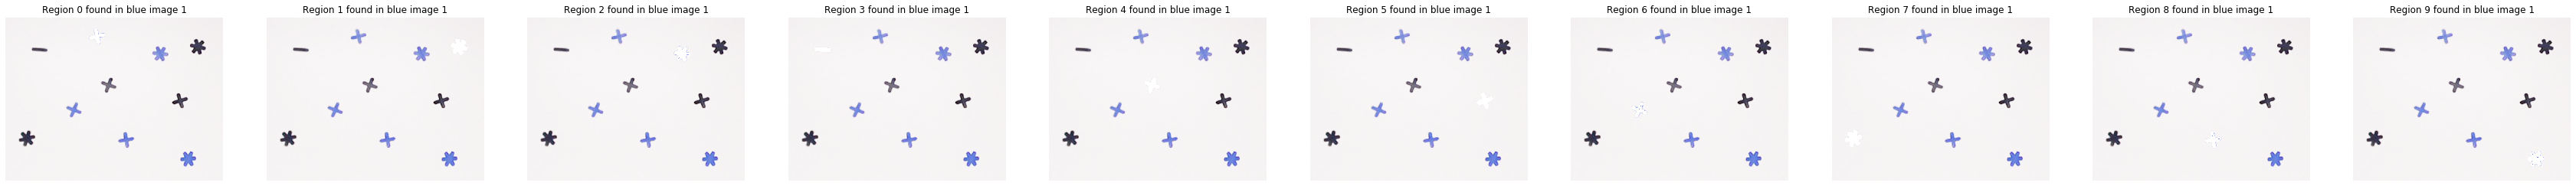

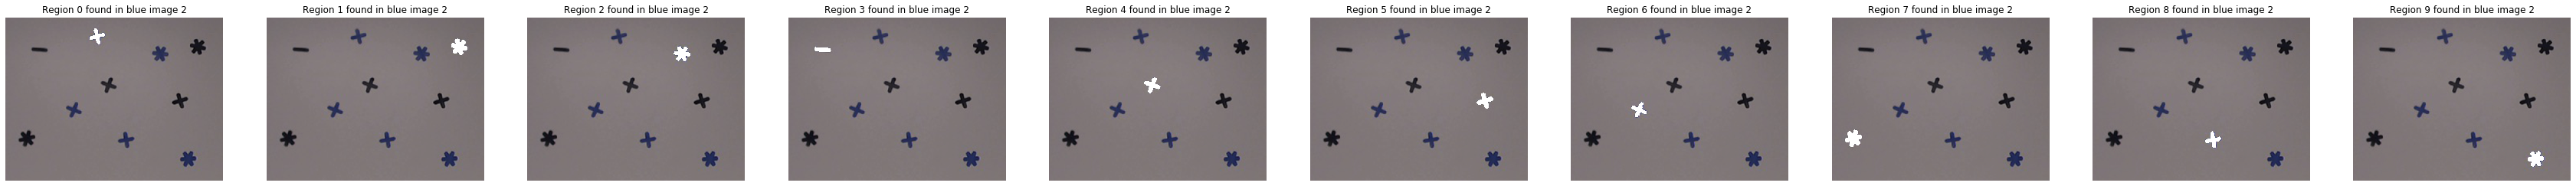

In [155]:
inds = [[markIndices(im, r) for r in region] for region, im in zip(all_regions, images)]
for j, ind in enumerate(inds):
    plotImages(ind, dsc=[f'Region {i} found in blue image {j}' for i in range(len(ind))])    

**Calculate** the mean pixel value for each region.

In [156]:
means = [[np.array([im[p] for p in r]).mean() for r in reg] for reg in all_regions]
means[0]

[122.15429234338747,
 26.275523560209425,
 122.10374414976599,
 46.426910299003325,
 35.837073170731706,
 28.556174558960073,
 121.87386363636364,
 31.959273182957393,
 121.74838012958963,
 121.02204261572373]

* These are the means of every group that is detected in image 0.
* They can easily be linked to the previously detected color peaks: 33, 133 and 175
* We could even separate them by SVM or regression.

However, our first thought was to do it by selecting the groups that yielded the least internal standard deviation.

In [157]:
import itertools
def allSubsetsOfList(s, l=None, subs=[]):
    if l==None: l = len(s)
    if l:
        for sub in itertools.combinations(s, l):
            subs.append(list(sub))
        allSubsetsOfList(s, l-1)
        
    return subs

In [158]:
possible_region_groups = allSubsetsOfList(range(len(means[0])))

**Idea:** split the list of means in two lists of every possible variation and select the list combinantion that yields the least combined internal standard deviation.

In [159]:
groups = []

for n, mean in enumerate(means):

    lowest_std = float('inf')
    lowest_std_indices_a = None
    lowest_std_indices_b = None

    for region_group in possible_region_groups:
        not_region_group = [j for j in range(len(mean)) if j not in region_group]

        group_a = [mean[i] for i in region_group]
        group_b = [mean[j] for j in not_region_group]
        total_std = 0
        if len(group_a): total_std += np.array(group_a).std()
        if len(group_b): total_std += np.array(group_b).std()
        if total_std < lowest_std:
            lowest_std = total_std
            lowest_std_indices_a = region_group
            lowest_std_indices_b = not_region_group
    groups.append((lowest_std_indices_a, lowest_std_indices_b))
    print(f'Indentified group A as regions {lowest_std_indices_a} and group B as regions {lowest_std_indices_b} in image {n}')

Indentified group A as regions [0, 2, 6, 8, 9] and group B as regions [1, 3, 4, 5, 7] in image 0
Indentified group A as regions [0, 2, 6, 8, 9] and group B as regions [1, 3, 4, 5, 7] in image 1
Indentified group A as regions [0, 2, 6, 8, 9] and group B as regions [1, 3, 4, 5, 7] in image 2


In [160]:
a_s = []
b_s = []
for i, im in enumerate(im_blues):
    a = []
    b = []

    for ga in groups[i][0]:
        for p in all_regions[i][ga]: a.append(p)
    for gb in groups[i][1]:
        for p in all_regions[i][gb]: b.append(p)
            
    a_s.append(a)
    b_s.append(b)

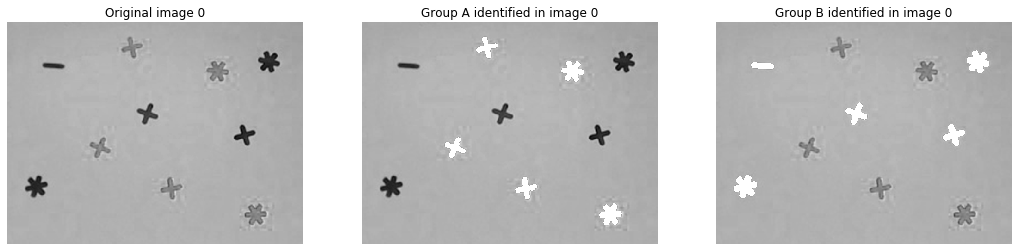

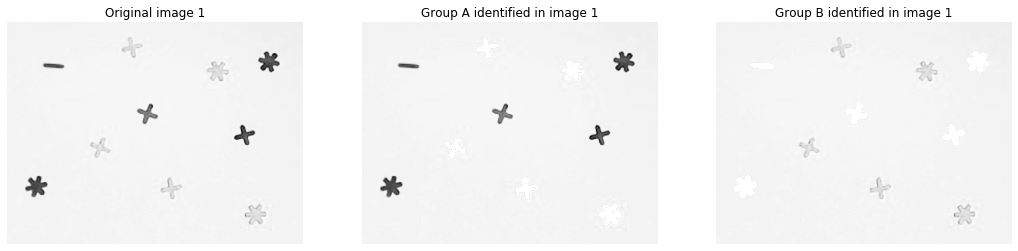

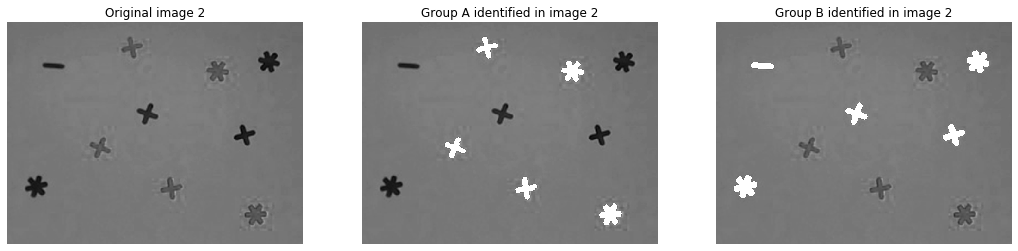

In [161]:
for i, im in enumerate(im_blues):
    ind_a = markIndices(im, a_s[i])
    ind_b = markIndices(im, b_s[i])
    plotImages([im, ind_a, ind_b], dsc=[f'Original image {i}', f'Group A identified in image {i}', f'Group B identified in image {i}'])

**And for the size estimation:**

In [162]:
i = 0
for a, b in zip(a_s, b_s):
    print(f'Image {i}. Estimated size of group A: {len(a)}. Estimated size of group B: {len(b)}')
    i += 1

Image 0. Estimated size of group A: 5311. Estimated size of group B: 5828
Image 1. Estimated size of group A: 4885. Estimated size of group B: 5573
Image 2. Estimated size of group A: 5352. Estimated size of group B: 5863


**Finishing thoughts:**
* The last method should probably be looked upon as a curiosity, but it proved that identifying the peaks in the histogram and removing the background based on it can yield useful results. At least in this case, where the background is quite uniform.
* Fitting a gaussian curve to the histogram could have been an interesting expansion on the task.


## Summary of Lab1
### Task 1
In this task we have provided 4 variants on how to segment out the brain. 3 of 4 ended up with somewhat similar result, and visually they also look quite nice.

### Task 2
In task two we have provided two methods. One where we try to fix the intensity problem with normalization etc., and one method that circumvents the problem by only only segmenting in the most distinct color; blue.  
The first method yields higher sizes per color, which might mean this problem gives works better in the edges.
